In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

####  Количество рабочих мест на всех видах работ по производству товаров и услуг (в среднем за год) (ОКВЭД2)

In [10]:
pd.read_excel('gks_data.xlsx').head(10)

,Unnamed: 0,Unnamed: 1,Количество рабочих мест на всех видах работ по производству товаров и услуг (в среднем за год) (ОКВЭД2),11231000100010200002 Количество рабочих мест на всех видах работ по производству товаров и услуг (в среднем за год) (ОКВЭД2)
0,NaN,NaN,2017 г.,2018 г.
1,Всего по обследуемым видам экономической деяте...,101.АГ,NaN,NaN
2,"СЕЛЬСКОЕ, ЛЕСНОЕ ХОЗЯЙСТВО, ОХОТА, РЫБОЛОВСТВО...",A,NaN,NaN
3,"Растениеводство и животноводство, охота и пред...",01,NaN,NaN
4,Российская Федерация,643,20923365,2.17111e+07
5,Центральный федеральный округ,030,4528193,4813968
6,Белгородская область,14000000000,361788,375698
7,Брянская область,15000000000,243928,273606
8,Владимирская область,17000000000,230866,233074
9,Воронежская область,20000000000,576305,617760


#### Более нормализованная версия

In [22]:
second_df = pd.read_excel('gks/gks_data_upd.xlsx', converters={'Код класса ОКВЭД-2':str})
print(second_df.shape)

part_1 = second_df.iloc[:, :-1]
part_1['Год'] = 2017
part_1.rename(columns={"Количество рабочих мест на всех видах работ по производству товаров и услуг (в среднем за год) (ОКВЭД2) 2017 г.": "Количество рабочих мест на всех видах работ по производству товаров и услуг"}, inplace=True)
print(f'Часть 1: {part_1.shape}')


part_2 = second_df.drop('Количество рабочих мест на всех видах работ по производству товаров и услуг (в среднем за год) (ОКВЭД2) 2017 г.', axis=1)
part_2['Год'] = 2018
part_2.rename(columns={"Количество рабочих мест на всех видах работ по производству товаров и услуг (в среднем за год) (ОКВЭД2) 2018 г.": "Количество рабочих мест на всех видах работ по производству товаров и услуг"}, inplace=True)

print(f'Часть 2: {part_2.shape}')

(5025, 8)
Часть 1: (5025, 8)
Часть 2: (5025, 8)


In [24]:
second_df = part_1.append(part_2)
second_df.head()

,Наименование раздела,Код раздела,Класс,Код класса ОКВЭД-2,АТО,ОКАТО,Количество рабочих мест на всех видах работ по производству товаров и услуг,Год
0,"СЕЛЬСКОЕ, ЛЕСНОЕ ХОЗЯЙСТВО, ОХОТА, РЫБОЛОВСТВО...",А,"Растениеводство и животноводство, охота и пред...",01,Российская Федерация,643,20923365.00,2017
1,"СЕЛЬСКОЕ, ЛЕСНОЕ ХОЗЯЙСТВО, ОХОТА, РЫБОЛОВСТВО...",А,"Растениеводство и животноводство, охота и пред...",01,Центральный федеральный округ,030,4528193.00,2017
2,"СЕЛЬСКОЕ, ЛЕСНОЕ ХОЗЯЙСТВО, ОХОТА, РЫБОЛОВСТВО...",А,"Растениеводство и животноводство, охота и пред...",01,Белгородская область,14000000000,361787.99,2017
3,"СЕЛЬСКОЕ, ЛЕСНОЕ ХОЗЯЙСТВО, ОХОТА, РЫБОЛОВСТВО...",А,"Растениеводство и животноводство, охота и пред...",01,Брянская область,15000000000,243928.00,2017
4,"СЕЛЬСКОЕ, ЛЕСНОЕ ХОЗЯЙСТВО, ОХОТА, РЫБОЛОВСТВО...",А,"Растениеводство и животноводство, охота и пред...",01,Владимирская область,17000000000,230866.00,2017


##### ERD

<img src="gks/gks_erd.png">

##### DFM

<img src="gks/gks_dfm.png">

##### Bipartite graph

In [1]:
class DfmNode:
    def __init__(self, dimensions, measures=[]):
        self.measures = measures
        self.dimensions = dimensions
        self.distant_measures = []
        
    def merge_measures(self):
        self.measures.extend(self.distant_measures)
        self.measures = list(set(self.measures))

In [2]:
dfm = {
    'Федеральный округ': DfmNode([], []),
    'ОКАТО': DfmNode(['Федеральный округ'], []),
    'РМ по производству товаров и услуг': DfmNode(['ОКАТО', 'ОКВЭД-2', 'Год'], []),
    'ОКВЭД-2': DfmNode([], []),
}

In [3]:
def add_previous(name):
    for dim in dfm[name].dimensions:
        if dim in dfm:
            dfm[name].distant_measures.extend([f'{name}/{m}' for m in dfm[dim].distant_measures])
            add_previous(dim)

In [6]:
measure_labels = ['_count']
for label in measure_labels:
    for key, value in dfm.items():
        #dfm[key].distant_measures.append(key + label) связи вида X_count(X)
        dfm[key].distant_measures.extend([f'{key}/{dim}{label}' for dim in value.dimensions])
        add_previous(key)
        dfm[key].merge_measures()

In [7]:
dfm['РМ по производству товаров и услуг'].measures

['РМ по производству товаров и услуг/ОКВЭД-2_count',
 'РМ по производству товаров и услуг/ОКАТО/Федеральный округ_count',
 'РМ по производству товаров и услуг/Год_count',
 'РМ по производству товаров и услуг/ОКАТО_count']

In [11]:
dimensions_set = set(dfm.keys())

In [13]:
measures_set = set()
for key, node in dfm.items():
    measures_set |= set(node.measures)
measures_set

{'ОКАТО/Федеральный округ_count',
 'РМ по производству товаров и услуг/Год_count',
 'РМ по производству товаров и услуг/ОКАТО/Федеральный округ_count',
 'РМ по производству товаров и услуг/ОКАТО_count',
 'РМ по производству товаров и услуг/ОКВЭД-2_count'}

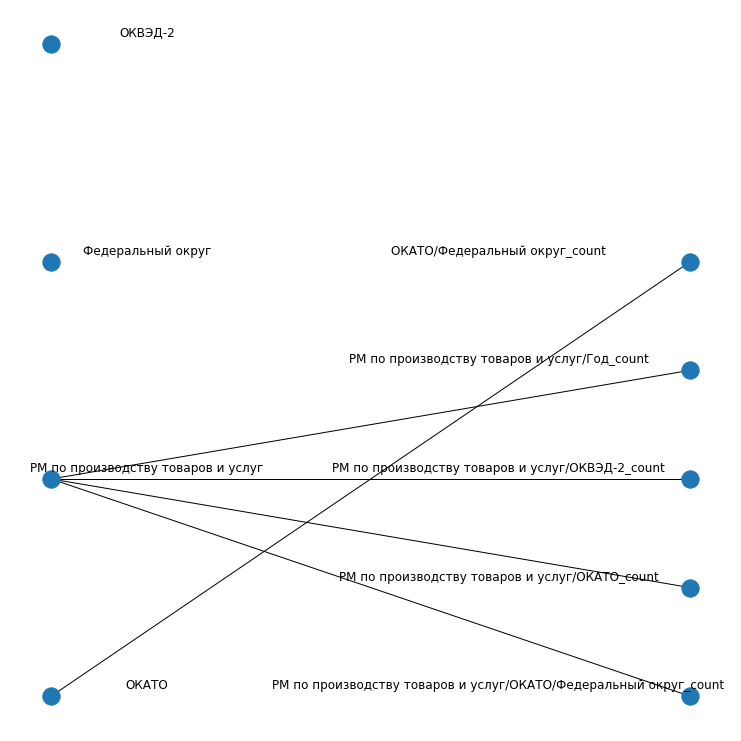

In [14]:
B = nx.Graph()
B.add_nodes_from(dimensions_set, bipartite=0) 
B.add_nodes_from(measures_set, bipartite=1)
edges = []
for key, node in dfm.items():
    for measure in node.measures:
        edges.append(
            (key, measure, 1)
        )
B.add_weighted_edges_from(edges, weight='weight')
 
#print(B.edges(data=True))
plt.figure(figsize=(10,10))
pos = {node:[0, i*2] for i, node in enumerate(dimensions_set)}
pos.update({node:[1, i] for i, node in enumerate(measures_set)})
nx.draw(B, pos, with_labels=False)
 
for p in pos:
    pos[p][0] = pos[p][0] - 0.3 if pos[p][0] == 1 else pos[p][0] + 0.15
    pos[p][1] += 0.1
nx.draw_networkx_labels(B, pos, color='r')

plt.show()